# DonorsChoose

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
!pip install chart_studio

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [107]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import chart_studio.plotly as py
import plotly.graph_objs as go
from collections import Counter

## 1.1 Reading Data

In [108]:
project_data = pd.read_csv('train_data.csv',nrows=30000)
resource_data = pd.read_csv('resources.csv')

In [109]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (30000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [110]:
project_data["project_is_approved"].value_counts()

1    25380
0     4620
Name: project_is_approved, dtype: int64

In [111]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]


project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
473,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,Mrs.,GA,2016-04-27 00:53:00,Grades PreK-2,Applied Learning,Early Development,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,"Benjamin Franklin once said, \""Tell me and I f...",My students need flexible seating in the class...,2,1
29891,146723,p099708,c0a28c79fe8ad5810da49de47b3fb491,Mrs.,CA,2016-04-27 01:10:09,Grades 3-5,"Math & Science, History & Civics","Mathematics, Social Sciences",Breakout Box to Ignite Engagement!,It's the end of the school year. Routines have...,"My students desire challenges, movement, and c...",I will design different clues using specific c...,Donations to this project will immediately imp...,"My students need items from a \""Breakout Box\""...",6,1


In [112]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


## 1.2 preprocessing of `project_subject_categories`

In [113]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [114]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.3 Text preprocessing

In [115]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [116]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay
473,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,Mrs.,GA,2016-04-27 00:53:00,Grades PreK-2,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,"Benjamin Franklin once said, \""Tell me and I f...",My students need flexible seating in the class...,2,1,AppliedLearning,EarlyDevelopment,I recently read an article about giving studen...
29891,146723,p099708,c0a28c79fe8ad5810da49de47b3fb491,Mrs.,CA,2016-04-27 01:10:09,Grades 3-5,Breakout Box to Ignite Engagement!,It's the end of the school year. Routines have...,"My students desire challenges, movement, and c...",I will design different clues using specific c...,Donations to this project will immediately imp...,"My students need items from a \""Breakout Box\""...",6,1,Math_Science History_Civics,Mathematics SocialSciences,It's the end of the school year. Routines have...


In [117]:
#### 1.4.2.3 Using Pretrained Models: TFIDF weighted W2V

In [118]:
# printing some random reviews
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
#print(project_data['essay'].values[20000])
#print("="*50)
#print(project_data['essay'].values[99999])
#print("="*50)

I recently read an article about giving students a choice about how they learn. We already set goals; why not let them choose where to sit, and give them options of what to sit on?I teach at a low-income (Title 1) school. Every year, I have a class with a range of abilities, yet they are all the same age. They learn differently, and they have different interests. Some have ADHD, and some are fast learners. Yet they are eager and active learners that want and need to be able to move around the room, yet have a place that they can be comfortable to complete their work.We need a classroom rug that we can use as a class for reading time, and students can use during other learning times. I have also requested four Kore Kids wobble chairs and four Back Jack padded portable chairs so that students can still move during whole group lessons without disrupting the class. Having these areas will provide these little ones with a way to wiggle while working.Benjamin Franklin once said, \"Tell me an

In [119]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [120]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

I have 63 students in three different math classes in a high poverty school. Many of these students come from single family homes and often stay with grandparents while their parent/parents work. \r\n\r\nEven though my students face many challenges, they are eager to learn new math concepts. I want to continue to give them the opportunity to learn their math concepts that will help them achieve a foundation to be successful in their future math journey. \r\n\r\nThank you for helping our future mathematicians succeed!Math is challenging. Students learn from making mistakes but with paper and pencils students at times erase so hard that they tear their paper. With the use of white boards and dry erase markers students can erase over and over  without having to worry about tearing their paper. \r\n\r\nWhite boards are a great tool to use in the classroom that will allow students to show their work from their seat and allow for some individualization and group work. \r\n\r\nStudents enjoy 

In [121]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

I have 63 students in three different math classes in a high poverty school. Many of these students come from single family homes and often stay with grandparents while their parent/parents work.     Even though my students face many challenges, they are eager to learn new math concepts. I want to continue to give them the opportunity to learn their math concepts that will help them achieve a foundation to be successful in their future math journey.     Thank you for helping our future mathematicians succeed!Math is challenging. Students learn from making mistakes but with paper and pencils students at times erase so hard that they tear their paper. With the use of white boards and dry erase markers students can erase over and over  without having to worry about tearing their paper.     White boards are a great tool to use in the classroom that will allow students to show their work from their seat and allow for some individualization and group work.     Students enjoy writing with a v

In [122]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

I have 63 students in three different math classes in a high poverty school Many of these students come from single family homes and often stay with grandparents while their parent parents work Even though my students face many challenges they are eager to learn new math concepts I want to continue to give them the opportunity to learn their math concepts that will help them achieve a foundation to be successful in their future math journey Thank you for helping our future mathematicians succeed Math is challenging Students learn from making mistakes but with paper and pencils students at times erase so hard that they tear their paper With the use of white boards and dry erase markers students can erase over and over without having to worry about tearing their paper White boards are a great tool to use in the classroom that will allow students to show their work from their seat and allow for some individualization and group work Students enjoy writing with a variety of writing tools an

In [123]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [124]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())


100%|██████████| 30000/30000 [00:16<00:00, 1807.28it/s]


In [125]:
# after preprocesing
#creating a new column with the preprocessed essays and replacing it with the original columns
project_data['preprocessed_essays'] = preprocessed_essays
project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)
preprocessed_essays[20000]

'63 students three different math classes high poverty school many students come single family homes often stay grandparents parent parents work even though students face many challenges eager learn new math concepts want continue give opportunity learn math concepts help achieve foundation successful future math journey thank helping future mathematicians succeed math challenging students learn making mistakes paper pencils students times erase hard tear paper use white boards dry erase markers students erase without worry tearing paper white boards great tool use classroom allow students show work seat allow individualization group work students enjoy writing variety writing tools use white boards dry erase markers feel students new excitement learning math nannan'

<h2><font color='red'> 1.4 Preprocessing of `project_title`</font></h2>

In [126]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())


100%|██████████| 30000/30000 [00:00<00:00, 37082.48it/s]


In [127]:
#creating a new column with the preprocessed titles,useful for analysis
project_data['preprocessed_titles'] = preprocessed_titles

In [128]:
#---------------------------------------------------------------------------------------
# Preprocessing Categorical Features: teacher_prefix
print(project_data['teacher_prefix'].value_counts())
print("="*100)

print(project_data[project_data['teacher_prefix'].isnull()]['teacher_prefix'])

print("="*100)
project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')
print(project_data['teacher_prefix'].value_counts())

print("="*100)
#---------------------------------------------------------------------------------------

Mrs.       15682
Ms.        10779
Mr.         2895
Teacher      643
Name: teacher_prefix, dtype: int64
7820    NaN
Name: teacher_prefix, dtype: object
Mrs.       15683
Ms.        10779
Mr.         2895
Teacher      643
Name: teacher_prefix, dtype: int64


In [129]:
#-------------------------------------------------------------------------------------------------------
# Preprocessing Categorical Features: project_grade_category
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ', '_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-', '_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
#-------------------------------------------------------------------------------------------------------

# Splitting data into Train, cross validation and test: Stratified Sampling

In [130]:
from sklearn.model_selection import train_test_split
#How to split whole dataset into Train,CV and test
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split
project_data_train, project_data_test, y_train, y_test = train_test_split(project_data, project_data['project_is_approved'], test_size=0.33, stratify = project_data['project_is_approved'])
project_data_train, project_data_cv, y_train, y_cv = train_test_split(project_data_train, y_train, test_size=0.33, stratify=y_train)
print(project_data_train.shape, project_data_cv.shape, y_train.shape, y_cv)

(13467, 16) (6633, 16) (13467,) 21576    1
1549     1
26045    1
3823     1
8340     1
        ..
18487    1
11139    1
28997    1
18595    1
20629    0
Name: project_is_approved, Length: 6633, dtype: int64


In [131]:
print("Split ratio")
print('-'*50)
print('Train dataset:',len(project_data_train)/len(project_data)*100,'%\n','size:',len(project_data_train))
print('Cross validation dataset:',len(project_data_cv)/len(project_data)*100,'%\n','size:',len(project_data_cv))
print('Test dataset:',len(project_data_test)/len(project_data)*100,'%\n','size:',len(project_data_test))

Split ratio
--------------------------------------------------
Train dataset: 44.89 %
 size: 13467
Cross validation dataset: 22.11 %
 size: 6633
Test dataset: 33.0 %
 size: 9900


In [132]:
#Features
project_data_train.drop(['project_is_approved'], axis=1, inplace=True)
project_data_cv.drop(['project_is_approved'], axis=1, inplace=True)
project_data_test.drop(['project_is_approved'], axis=1, inplace=True)

## 1.5 Preparing data for models

In [133]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay',
       'preprocessed_essays', 'preprocessed_titles'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### 1.5.1 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

In [134]:
def VectorizingData(sFeature, project_data_fitting,project_data_transform):
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer_feature = CountVectorizer(lowercase=False, binary=True)
    vectorizer_feature.fit(project_data_fitting[sFeature].values) #fitting has to be on Train data

    transform_one_hot = vectorizer_feature.transform(project_data_transform[sFeature].values)
    #print(vectorizer_cat.get_feature_names())
    return(transform_one_hot)
    

In [135]:
train_categories_one_hot = VectorizingData("clean_categories", project_data_train, project_data_train)
cv_categories_one_hot = VectorizingData("clean_categories", project_data_train, project_data_cv)
test_categories_one_hot = VectorizingData("clean_categories", project_data_train, project_data_test)

print("Shape of training data matrix after one hot encoding ",train_categories_one_hot.shape)
print("Shape of cross validation data matrix after one hot encoding ",cv_categories_one_hot.shape)
print("Shape of test data matrix after one hot encoding ",test_categories_one_hot.shape)

Shape of training data matrix after one hot encoding  (13467, 9)
Shape of cross validation data matrix after one hot encoding  (6633, 9)
Shape of test data matrix after one hot encoding  (9900, 9)


In [136]:
train_subcategories_one_hot = VectorizingData('clean_subcategories', project_data_train, project_data_train)
cv_subcategories_one_hot = VectorizingData('clean_subcategories', project_data_train, project_data_cv)
test_subcategories_one_hot = VectorizingData('clean_subcategories', project_data_train, project_data_test)

print("Shape of train data matrix after one hot encoding ",train_subcategories_one_hot.shape)
print("Shape of cross validation data matrix after one hot encoding ",cv_subcategories_one_hot.shape)
print("Shape of test data matrix after one hot encoding ",test_subcategories_one_hot.shape)

Shape of train data matrix after one hot encoding  (13467, 30)
Shape of cross validation data matrix after one hot encoding  (6633, 30)
Shape of test data matrix after one hot encoding  (9900, 30)


In [137]:
train_school_state_category_one_hot = VectorizingData('school_state', project_data_train, project_data_train)
cv_school_state_category_one_hot = VectorizingData('school_state', project_data_train, project_data_cv)
test_school_state_category_one_hot = VectorizingData('school_state', project_data_train, project_data_test)


print("Shape of train data matrix after one hot encoding ",train_school_state_category_one_hot.shape)
print("Shape of cross validation data matrix after one hot encoding ",cv_school_state_category_one_hot.shape)
print("Shape of test data matrix after one hot encoding ",test_school_state_category_one_hot.shape)

Shape of train data matrix after one hot encoding  (13467, 51)
Shape of cross validation data matrix after one hot encoding  (6633, 51)
Shape of test data matrix after one hot encoding  (9900, 51)


In [138]:
train_project_grade_category_one_hot = VectorizingData('project_grade_category', project_data_train, project_data_train)
cv_project_grade_category_one_hot = VectorizingData('project_grade_category', project_data_train, project_data_cv)
test_project_grade_category_one_hot = VectorizingData('project_grade_category', project_data_train, project_data_test)


print("Shape of train data matrix after one hot encoding ",train_project_grade_category_one_hot.shape)
print("Shape of cross validation data matrix after one hot encoding ",cv_project_grade_category_one_hot.shape)
print("Shape of test data matrix after one hot encoding ",test_project_grade_category_one_hot.shape)

Shape of train data matrix after one hot encoding  (13467, 4)
Shape of cross validation data matrix after one hot encoding  (6633, 4)
Shape of test data matrix after one hot encoding  (9900, 4)


In [139]:
train_teacher_prefix_categories_one_hot = VectorizingData('teacher_prefix', project_data_train, project_data_train)
cv_teacher_prefix_categories_one_hot = VectorizingData('teacher_prefix', project_data_train, project_data_cv)
test_teacher_prefix_categories_one_hot = VectorizingData('teacher_prefix', project_data_train, project_data_test)

print("Shape of train data matrix after one hot encoding ",train_teacher_prefix_categories_one_hot.shape)
print("Shape of cross validation data matrix after one hot encoding ",cv_teacher_prefix_categories_one_hot.shape)
print("Shape of test data matrix after one hot encoding ",test_teacher_prefix_categories_one_hot.shape)

Shape of train data matrix after one hot encoding  (13467, 4)
Shape of cross validation data matrix after one hot encoding  (6633, 4)
Shape of test data matrix after one hot encoding  (9900, 4)


### 1.5.2 Vectorizing Text data

#### 1.5.2.1 Bag of words

In [140]:
train_essay_bow = VectorizingData('essay', project_data_train, project_data_train)
cv_essay_bow = VectorizingData('essay', project_data_train, project_data_cv)
test_essay_bow = VectorizingData('essay', project_data_train, project_data_test)

print("Shape of train data matrix after one hot encoding ",train_essay_bow.shape)
print("Shape of cross validation data matrix after one hot encoding ",cv_essay_bow.shape)
print("Shape of test data matrix after one hot encoding ",test_essay_bow.shape)

Shape of train data matrix after one hot encoding  (13467, 32793)
Shape of cross validation data matrix after one hot encoding  (6633, 32793)
Shape of test data matrix after one hot encoding  (9900, 32793)


In [141]:
train_title_bow = VectorizingData('preprocessed_titles', project_data_train, project_data_train)
cv_title_bow = VectorizingData('preprocessed_titles', project_data_train, project_data_cv)
test_title_bow = VectorizingData('preprocessed_titles', project_data_train, project_data_test)

print("Shape of train data matrix after one hot encoding ",train_title_bow.shape)
print("Shape of cross validation data matrix after one hot encoding ",cv_title_bow.shape)
print("Shape of test data matrix after one hot encoding ",test_title_bow.shape)

Shape of train data matrix after one hot encoding  (13467, 6318)
Shape of cross validation data matrix after one hot encoding  (6633, 6318)
Shape of test data matrix after one hot encoding  (9900, 6318)


#### 1.5.2.2 tfidf

In [142]:
def tfidf_Vectorizer(sFeature, project_data_fitting,project_data_transform):
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer_tfidf_feature = TfidfVectorizer(min_df=10)
    vectorizer_tfidf_feature.fit(project_data_train[sFeature])      #Fitting has to be on Train data

    tfidf_vect = vectorizer_tfidf_feature.transform(project_data_transform[sFeature].values)
    return(tfidf_vect)

In [143]:
train_essay_tfidf = tfidf_Vectorizer('preprocessed_essays',  project_data_train, project_data_train)
cv_essay_tfidf = tfidf_Vectorizer('preprocessed_essays',  project_data_train, project_data_cv)
test_essay_tfidf = tfidf_Vectorizer('preprocessed_essays',  project_data_train, project_data_test)

print("Shape of train data matrix after one hot encoding ",train_essay_tfidf.shape)
print("Shape of cross validation data matrix after one hot encoding ",cv_essay_tfidf.shape)
print("Shape of test data matrix after one hot encoding ",test_essay_tfidf.shape)

Shape of train data matrix after one hot encoding  (13467, 6997)
Shape of cross validation data matrix after one hot encoding  (6633, 6997)
Shape of test data matrix after one hot encoding  (9900, 6997)


In [144]:
train_title_tfidf = tfidf_Vectorizer('preprocessed_titles',  project_data_train, project_data_train)
cv_title_tfidf = tfidf_Vectorizer('preprocessed_titles',  project_data_train, project_data_cv)
test_title_tfidf = tfidf_Vectorizer('preprocessed_titles',  project_data_train, project_data_test)

print("Shape of train data matrix after one hot encoding ",train_title_tfidf.shape)
print("Shape of cross validation data matrix after one hot encoding ",cv_title_tfidf.shape)
print("Shape of test data matrix after one hot encoding ",test_title_tfidf.shape)

Shape of train data matrix after one hot encoding  (13467, 854)
Shape of cross validation data matrix after one hot encoding  (6633, 854)
Shape of test data matrix after one hot encoding  (9900, 854)


#### 1.5.2.3 Using Pretrained Models: TFIDF weighted W2V

In [145]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [146]:

# average Word2Vec
# compute average word2vec for each review.
train_avg_w2v_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(project_data_train['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_avg_w2v_essays.append(vector)

print(len(train_avg_w2v_essays))
print(len(train_avg_w2v_essays[0]))


100%|██████████| 13467/13467 [00:04<00:00, 3027.34it/s]

13467
300


In [147]:
# average Word2Vec
# compute average word2vec for each review.
cv_avg_w2v_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(project_data_cv['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    cv_avg_w2v_essays.append(vector)

print(len(cv_avg_w2v_essays))
print(len(cv_avg_w2v_essays[0]))


100%|██████████| 6633/6633 [00:02<00:00, 2976.05it/s]

6633
300


In [148]:
# compute average word2vec for each review.
test_avg_w2v_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(project_data_test['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_avg_w2v_essays.append(vector)

print(len(test_avg_w2v_essays))
print(len(test_avg_w2v_essays[0]))


100%|██████████| 9900/9900 [00:03<00:00, 2960.61it/s]

9900
300


In [149]:
# average Word2Vec
# compute average word2vec for each review.
train_avg_w2v_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(project_data_train['preprocessed_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_avg_w2v_titles.append(vector)

print(len(train_avg_w2v_titles))
print(len(train_avg_w2v_titles[0]))


100%|██████████| 13467/13467 [00:00<00:00, 50827.72it/s]

13467
300


In [150]:
# average Word2Vec
# compute average word2vec for each review.
cv_avg_w2v_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(project_data_cv['preprocessed_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    cv_avg_w2v_titles.append(vector)

print(len(cv_avg_w2v_titles))
print(len(cv_avg_w2v_titles[0]))


100%|██████████| 6633/6633 [00:00<00:00, 50737.36it/s]

6633
300


In [151]:
# average Word2Vec
# compute average word2vec for each review.
test_avg_w2v_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(project_data_test['preprocessed_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_avg_w2v_titles.append(vector)

print(len(test_avg_w2v_titles))
print(len(test_avg_w2v_titles[0]))


100%|██████████| 9900/9900 [00:00<00:00, 58174.65it/s]

9900
300


#### 1.5.2.3 Using Pretrained Models: TFIDF weighted W2V

In [152]:
# Similarly you can vectorize for title also
tfidf_model = TfidfVectorizer()
tfidf_model.fit(project_data_train['preprocessed_titles'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [153]:
# average Word2Vec
# compute average word2vec for each review.
train_tfidf_w2v_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(project_data_train['preprocessed_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_titles.append(vector)

print(len(train_tfidf_w2v_titles))
print(len(train_tfidf_w2v_titles[0]))


100%|██████████| 13467/13467 [00:00<00:00, 16936.49it/s]

13467
300


In [154]:
# average Word2Vec
# compute average word2vec for each review.
cv_tfidf_w2v_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(project_data_cv['preprocessed_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    cv_tfidf_w2v_titles.append(vector)

print(len(cv_tfidf_w2v_titles))
print(len(cv_tfidf_w2v_titles[0]))


100%|██████████| 6633/6633 [00:00<00:00, 22833.65it/s]

6633
300


In [155]:
# compute average word2vec for each review.
test_tfidf_w2v_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(project_data_test['preprocessed_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_titles.append(vector)

print(len(test_tfidf_w2v_titles))
print(len(test_tfidf_w2v_titles[0]))


100%|██████████| 9900/9900 [00:00<00:00, 22151.86it/s]

9900
300


In [156]:
# Similarly you can vectorize for title also
tfidf_model = TfidfVectorizer()
tfidf_model.fit(project_data_train['preprocessed_essays'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [157]:
# average Word2Vec
# compute average word2vec for each review.
train_tfidf_w2v_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(project_data_train['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_essays.append(vector)

print(len(train_tfidf_w2v_essays))
print(len(train_tfidf_w2v_essays[0]))


100%|██████████| 13467/13467 [00:28<00:00, 466.55it/s]

13467
300


In [158]:
# average Word2Vec
# compute average word2vec for each review.
cv_tfidf_w2v_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(project_data_cv['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    cv_tfidf_w2v_essays.append(vector)

print(len(cv_tfidf_w2v_essays))
print(len(cv_tfidf_w2v_essays[0]))


100%|██████████| 6633/6633 [00:14<00:00, 472.30it/s]

6633
300


In [159]:
# compute average word2vec for each review.
test_tfidf_w2v_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(project_data_test['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_essays.append(vector)

print(len(test_tfidf_w2v_essays))
print(len(test_tfidf_w2v_essays[0]))


100%|██████████| 9900/9900 [00:21<00:00, 467.14it/s]

9900
300


### 1.5.3 Vectorizing Numerical features

In [160]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()

project_data_train = pd.merge(project_data_train, price_data, on='id', how='left')
project_data_cv = pd.merge(project_data_cv, price_data, on='id', how='left')
project_data_test = pd.merge(project_data_test, price_data, on='id', how='left')

In [161]:
from sklearn.preprocessing import Normalizer
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer = Normalizer()
normalizer.fit(project_data_train['price'].values.reshape(-1,1)) 


price_normalized_train = normalizer.transform(project_data_train['price'].values.reshape(-1, 1))
price_normalized_cv = normalizer.transform(project_data_cv['price'].values.reshape(-1, 1))
price_normalized_test = normalizer.transform(project_data_test['price'].values.reshape(-1, 1))


print('After normalization')
print(price_normalized_train.shape)
print(price_normalized_cv.shape)
print(price_normalized_test.shape)

After normalization
(13467, 1)
(6633, 1)
(9900, 1)


In [162]:
normalizer = Normalizer()
normalizer.fit(project_data_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) 


# Now standardize the data with above maen and variance.
previously_posted_projects_normalized_train = normalizer.transform(project_data_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
previously_posted_projects_normalized_cv = normalizer.transform(project_data_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
previously_posted_projects_normalized_test = normalizer.transform(project_data_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))


print('After normalization')
print(previously_posted_projects_normalized_train.shape)
print(previously_posted_projects_normalized_cv.shape)
print(previously_posted_projects_normalized_test.shape)

After normalization
(13467, 1)
(6633, 1)
(9900, 1)


# Assignment 3: Apply KNN

<ol>
    <li><strong>[Task-1] Apply KNN(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + project_title(TFIDF)+  preprocessed_essay (TFIDF)</li>
            <li><font color='red'>Set 3</font>: categorical, numerical features + project_title(AVG W2V)+  preprocessed_essay (AVG W2V)</li>
            <li><font color='red'>Set 4</font>: categorical, numerical features + project_title(TFIDF W2V)+  preprocessed_essay (TFIDF W2V)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning to find best K</strong>
        <ul>
    <li>Find the best hyper parameter which results in the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation (or) simple cross validation data</li>
    <li>Use gridsearch-cv or randomsearch-cv or  write your own for loops to do this task</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, as shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once you find the best hyper parameter, you need to train your model-M using the best hyper-param. Now, find the AUC on test data and plot the ROC curve on both train and test using model-M.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <li><strong> [Task-2] </strong>
        <ul>
            <li>Select top 2000 features from feature <font color='red'>Set 2</font> using <a href='https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html'>`SelectKBest`</a>
and then apply KNN on top of these features</li>
            <li>
                <pre>
                from sklearn.datasets import load_digits
                from sklearn.feature_selection import SelectKBest, chi2
                X, y = load_digits(return_X_y=True)
                X.shape
                X_new = SelectKBest(chi2, k=20).fit_transform(X, y)
                X_new.shape
                ========
                output:
                (1797, 64)
                (1797, 20)
                </pre>
            </li>
            <li>Repeat the steps 2 and 3 on the data matrix after feature selection</li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

<h1>2. K Nearest Neighbor</h1>

<h2>2.1 Set 1: categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW)</h2>

In [163]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train = hstack((train_categories_one_hot, train_subcategories_one_hot, train_essay_bow, train_title_bow, train_school_state_category_one_hot,train_teacher_prefix_categories_one_hot, previously_posted_projects_normalized_train, train_project_grade_category_one_hot, price_normalized_train)).tocsr()
X_cv = hstack((cv_categories_one_hot, cv_subcategories_one_hot, cv_essay_bow, cv_title_bow, cv_school_state_category_one_hot, cv_teacher_prefix_categories_one_hot, previously_posted_projects_normalized_cv, cv_project_grade_category_one_hot, price_normalized_cv)).tocsr()
X_test = hstack((test_categories_one_hot, test_subcategories_one_hot, test_essay_bow, test_title_bow, test_school_state_category_one_hot, test_teacher_prefix_categories_one_hot, previously_posted_projects_normalized_test, test_project_grade_category_one_hot, price_normalized_test)).tocsr()

print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(13467, 39211)
(6633, 39211)
(9900, 39211)


### 2.1.1 Without using function:GridSearchCV


100%|██████████| 12/12 [09:12<00:00, 46.08s/it]


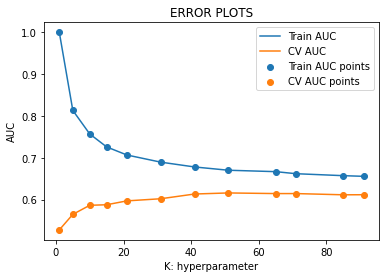

In [167]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
train_auc = []
cv_auc = [] 
K = [1, 5, 10, 15, 21, 31, 41, 51, 65, 71, 85, 91]# min k causes overfitting, max k causes underfitting
#K = range(1,50,2)
for i in  tqdm(K):
  
    neigh1 = KNeighborsClassifier(n_neighbors=i,algorithm='brute')# takes the k from the  i th list value
    neigh1.fit(X_train, y_train)# fit the model
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh1.predict_proba(X_train)[:,1]#Return probability estimates for the  set1x ,for the class label 1 or +ve.
    y_cv_pred =  neigh1.predict_proba(X_cv)[:,1]#Return probability estimates for the setcvx,for the class label 1 or +ve .
    
    # roc curve
    #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')


plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()                

In [195]:
score_t_train = [x for x in train_auc]
score_t_cv = [x for x in cv_auc]

diff_score_train_cv = list(set(score_t_train) - set(score_t_cv))
opt_t_cv = K[diff_score_train_cv.index(min(diff_score_train_cv))]
best_k=opt_t_cv
print(best_k)

91


### Train the model using the best hyperparameter that will maximise AUC score

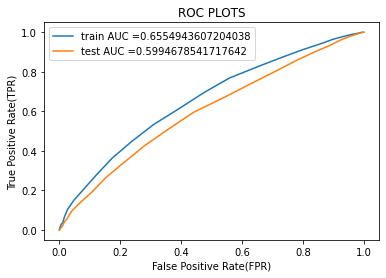

In [196]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh1 = KNeighborsClassifier(n_neighbors=best_k,algorithm='brute')
neigh1.fit(X_train ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  neigh1.predict_proba(X_train)[:,1]#Return probability estimates for the  set1x ,for the class label 1 or +ve.
y_test_pred =  neigh1.predict_proba(X_test)[:,1]#Return probability estimates for the setcvx,for the class label 1 or +ve .

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh1.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh1.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC PLOTS")
plt.show()

### 2.1.2 Using function:GridSearchCV

In [197]:
# # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import KNeighborsClassifier
# neigh = KNeighborsClassifier()

# parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51, 65, 71, 85, 91]}

# clf = GridSearchCV(neigh, parameters, cv= 5, scoring='roc_auc')

# clf.fit(X_train, y_train)

# train_auc= clf.cv_results_['mean_train_score']
# train_auc_std= clf.cv_results_['std_train_score']
# cv_auc = clf.cv_results_['mean_test_score']
# cv_auc_std= clf.cv_results_['std_test_score']
# print()

# plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
# # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

# plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
# # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

# plt.scatter(parameters['n_neighbors'], train_auc, label='Train AUC points')
# plt.scatter(parameters['n_neighbors'], cv_auc, label='CV AUC points')


# plt.legend()
# plt.xlabel("K: hyperparameter")
# plt.ylabel("AUC")
# plt.title("ERROR PLOTS")
# plt.grid()
# plt.show()

In [198]:
#https://datascience.stackexchange.com/questions/21877/how-to-use-the-output-of-gridsearch
#choosing the best hyperparameter
#clf.best_params_

### Train the model using the best hyperparameter that will maximise AUC score using GridSearchCV

In [199]:
#best_k1 = clf.best_params_['n_neighbors']

In [200]:
# def batch_predict(clf, data):
#     # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
#     # not the predicted outputs

#     y_data_pred = []
#     tr_loop = data.shape[0] - data.shape[0]%1000
#     # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
#     # in this for loop we will iterate unti the last 1000 multiplier
#     for i in range(0, tr_loop, 1000):
#         y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
#     # we will be predicting for the last data points
#     y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
#     return y_data_pred

In [201]:
# # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
# from sklearn.metrics import roc_curve, auc
# from sklearn.neighbors import KNeighborsClassifier

# neigh = KNeighborsClassifier(n_neighbors=best_k1)
# neigh.fit(X_train, y_train)
# # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# # not the predicted outputs

# y_train_pred = batch_predict(neigh, X_train)    
# y_test_pred = batch_predict(neigh, X_test)

# train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
# test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)

# plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
# plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
# plt.legend()
# plt.xlabel("True Positive Rate(TPR)")
# plt.ylabel("False Positive Rate(FPR)")
# plt.title("AUC")
# plt.grid()
# plt.show()

### Confusion Matrix of Train and Test Data

In [202]:
from sklearn.metrics import classification_report

print(classification_report(y_train,neigh1.predict(X_train) ))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2074
           1       0.85      1.00      0.92     11393

    accuracy                           0.85     13467
   macro avg       0.42      0.50      0.46     13467
weighted avg       0.72      0.85      0.78     13467



In [203]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [204]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.3720965968969933 for threshold 0.769
Train confusion matrix
[[1253  821]
 [4376 7017]]
Test confusion matrix
[[ 851  674]
 [3386 4989]]


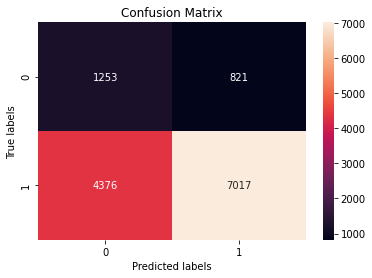

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt   

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True, ax = ax,fmt='g');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');


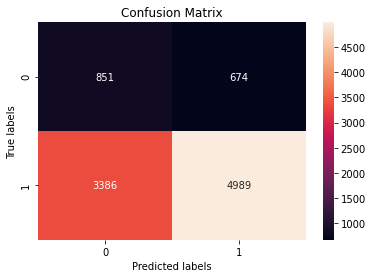

In [206]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True, ax = ax,fmt='g');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

### 2.2 Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_essay (TFIDF)

In [207]:
# Please write all the code with proper documentation

X_train = hstack((train_categories_one_hot, train_subcategories_one_hot, train_essay_tfidf, train_title_tfidf, train_school_state_category_one_hot,train_teacher_prefix_categories_one_hot, previously_posted_projects_normalized_train, train_project_grade_category_one_hot, price_normalized_train)).tocsr()
X_cv = hstack((cv_categories_one_hot, cv_subcategories_one_hot, cv_essay_tfidf, cv_title_tfidf, cv_school_state_category_one_hot, cv_teacher_prefix_categories_one_hot, previously_posted_projects_normalized_cv, cv_project_grade_category_one_hot, price_normalized_cv)).tocsr()
X_test = hstack((test_categories_one_hot, test_subcategories_one_hot, test_essay_tfidf, test_title_tfidf, test_school_state_category_one_hot, test_teacher_prefix_categories_one_hot, previously_posted_projects_normalized_test, test_project_grade_category_one_hot, price_normalized_test)).tocsr()

In [208]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(13467, 7951)
(6633, 7951)
(9900, 7951)



100%|██████████| 12/12 [05:26<00:00, 27.19s/it]


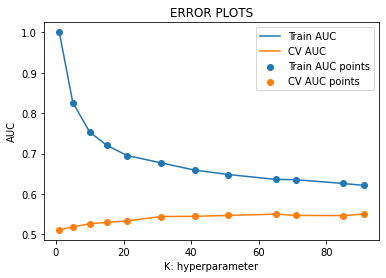

In [209]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
train_auc = []
cv_auc = [] 
K = [1, 5, 10, 15, 21, 31, 41, 51, 65, 71, 85, 91]# min k causes overfitting, max k causes underfitting
#K = range(1,50,2)
for i in  tqdm(K):
  
    neigh2 = KNeighborsClassifier(n_neighbors=i,algorithm='brute')# takes the k from the  i th list value
    neigh2.fit(X_train, y_train)# fit the model
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh2.predict_proba(X_train)[:,1]#Return probability estimates for the  set1x ,for the class label 1 or +ve.
    y_cv_pred =  neigh2.predict_proba(X_cv)[:,1]#Return probability estimates for the setcvx,for the class label 1 or +ve .
    
    # roc curve
    #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')


plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()                

In [210]:
score_t_train = [x for x in train_auc]
score_t_cv = [x for x in cv_auc]

diff_score_train_cv = list(set(score_t_train) - set(score_t_cv))
opt_t_cv = K[diff_score_train_cv.index(min(diff_score_train_cv))]
best_k=opt_t_cv
print(best_k)

85


### Train the model using the best hyperparameter that will maximise AUC score

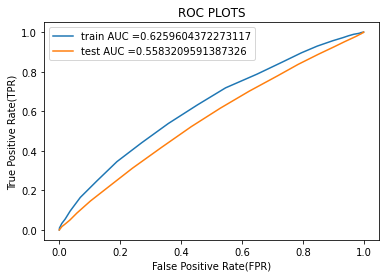

In [211]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh2 = KNeighborsClassifier(n_neighbors=best_k,algorithm='brute')
neigh2.fit(X_train ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  neigh2.predict_proba(X_train)[:,1]#Return probability estimates for the  set1x ,for the class label 1 or +ve.
y_test_pred =  neigh2.predict_proba(X_test)[:,1]#Return probability estimates for the setcvx,for the class label 1 or +ve .

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh2.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh2.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC PLOTS")
plt.show()

### Confusion Matrix of Train and Test Data

In [212]:
from sklearn.metrics import classification_report

print(classification_report(y_train,neigh2.predict(X_train) ))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2074
           1       0.85      1.00      0.92     11393

    accuracy                           0.85     13467
   macro avg       0.42      0.50      0.46     13467
weighted avg       0.72      0.85      0.78     13467



In [213]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.34546509254993485 for threshold 0.859
Train confusion matrix
[[1331  743]
 [5260 6133]]
Test confusion matrix
[[ 864  661]
 [4001 4374]]


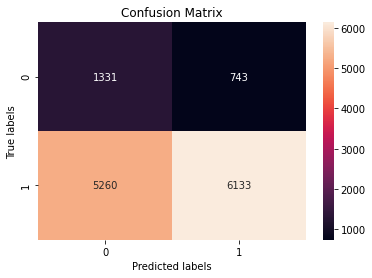

In [214]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True, ax = ax,fmt='g');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

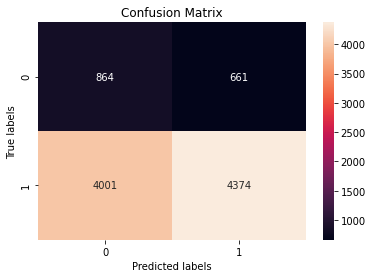

In [215]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True, ax = ax,fmt='g');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

### 2.3 Set 3: categorical, numerical features + project_title(AVG W2V)+ preprocessed_essay (AVG W2V)

In [216]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train = hstack((train_categories_one_hot, train_subcategories_one_hot, train_avg_w2v_essays, train_avg_w2v_titles, train_school_state_category_one_hot,train_teacher_prefix_categories_one_hot, previously_posted_projects_normalized_train, train_project_grade_category_one_hot, price_normalized_train)).tocsr()
X_cv = hstack((cv_categories_one_hot, cv_subcategories_one_hot, cv_avg_w2v_essays, cv_avg_w2v_titles, cv_school_state_category_one_hot, cv_teacher_prefix_categories_one_hot, previously_posted_projects_normalized_cv, cv_project_grade_category_one_hot, price_normalized_cv)).tocsr()
X_test = hstack((test_categories_one_hot, test_subcategories_one_hot, test_avg_w2v_essays, test_avg_w2v_titles, test_school_state_category_one_hot, test_teacher_prefix_categories_one_hot, previously_posted_projects_normalized_test, test_project_grade_category_one_hot, price_normalized_test)).tocsr()

In [217]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(13467, 700)
(6633, 700)
(9900, 700)



100%|██████████| 12/12 [1:41:23<00:00, 506.99s/it]


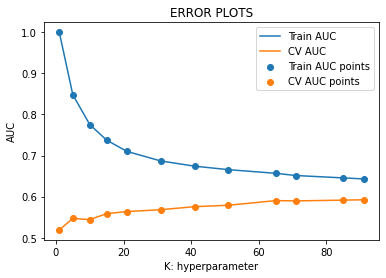

In [218]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
train_auc = []
cv_auc = [] 
K = [1, 5, 10, 15, 21, 31, 41, 51, 65, 71, 85, 91]# min k causes overfitting, max k causes underfitting
#K = range(1,50,2)
for i in  tqdm(K):
  
    neigh3 = KNeighborsClassifier(n_neighbors=i,algorithm='brute')# takes the k from the  i th list value
    neigh3.fit(X_train, y_train)# fit the model
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh3.predict_proba(X_train)[:,1]#Return probability estimates for the  set1x ,for the class label 1 or +ve.
    y_cv_pred =  neigh3.predict_proba(X_cv)[:,1]#Return probability estimates for the setcvx,for the class label 1 or +ve .
    
    # roc curve
    #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')


plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()                

In [219]:
score_t_train = [x for x in train_auc]
score_t_cv = [x for x in cv_auc]

diff_score_train_cv = list(set(score_t_train) - set(score_t_cv))
opt_t_cv = K[diff_score_train_cv.index(min(diff_score_train_cv))]
best_k=opt_t_cv
print(best_k)

91


### Train the model using the best hyperparameter that will maximise AUC score

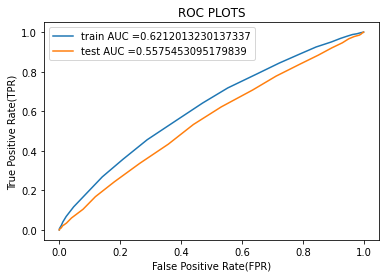

In [222]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh3 = KNeighborsClassifier(n_neighbors=best_k,algorithm='brute')
neigh3.fit(X_train ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  neigh3.predict_proba(X_train)[:,1]#Return probability estimates for the  set1x ,for the class label 1 or +ve.
y_test_pred =  neigh3.predict_proba(X_test)[:,1]#Return probability estimates for the setcvx,for the class label 1 or +ve .

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh3.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh3.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC PLOTS")
plt.show()

### Confusion Matrix of Train and Test Data

In [223]:
from sklearn.metrics import classification_report

print(classification_report(y_train,neigh3.predict(X_train) ))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2074
           1       0.85      1.00      0.92     11393

    accuracy                           0.85     13467
   macro avg       0.42      0.50      0.46     13467
weighted avg       0.72      0.85      0.78     13467



In [224]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.3407106547770243 for threshold 0.857
Train confusion matrix
[[1284  790]
 [5123 6270]]
Test confusion matrix
[[ 853  672]
 [3908 4467]]


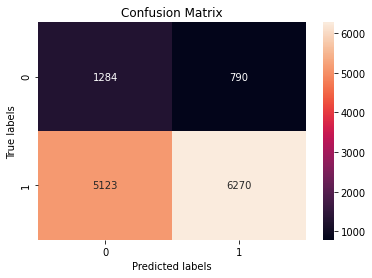

In [225]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True, ax = ax,fmt='g');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

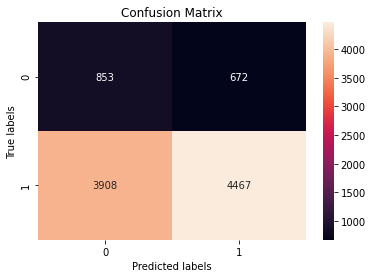

In [226]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True, ax = ax,fmt='g');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');


### 2.4 Set 4: categorical, numerical features + project_title(TFIDF W2V)+ preprocessed_essay (TFIDF W2V)

In [242]:
X_train = hstack((train_categories_one_hot, train_subcategories_one_hot, train_school_state_category_one_hot, train_project_grade_category_one_hot, train_teacher_prefix_categories_one_hot, price_normalized_train ,  previously_posted_projects_normalized_train, train_tfidf_w2v_essays, train_tfidf_w2v_titles)).tocsr()
X_test = hstack((test_categories_one_hot, test_subcategories_one_hot, test_school_state_category_one_hot, test_project_grade_category_one_hot, test_teacher_prefix_categories_one_hot, price_normalized_test,  previously_posted_projects_normalized_test, test_tfidf_w2v_essays, test_tfidf_w2v_titles)).tocsr()
X_cv = hstack((cv_categories_one_hot, cv_subcategories_one_hot, cv_school_state_category_one_hot, cv_project_grade_category_one_hot, cv_teacher_prefix_categories_one_hot, price_normalized_cv,previously_posted_projects_normalized_cv,  cv_tfidf_w2v_essays, cv_tfidf_w2v_titles)).tocsr()

In [243]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(13467, 700)
(6633, 700)
(9900, 700)



100%|██████████| 12/12 [1:41:42<00:00, 508.57s/it]


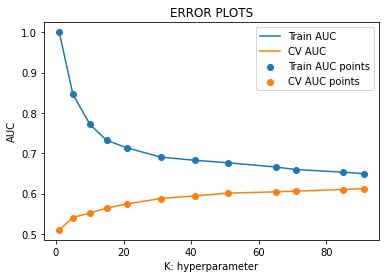

In [244]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
train_auc = []
cv_auc = [] 
K = [1, 5, 10, 15, 21, 31, 41, 51, 65, 71, 85, 91]# min k causes overfitting, max k causes underfitting
#K = range(1,50,2)
for i in  tqdm(K):
  
    neigh4 = KNeighborsClassifier(n_neighbors=i,algorithm='brute')# takes the k from the  i th list value
    neigh4.fit(X_train, y_train)# fit the model
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh4.predict_proba(X_train)[:,1]#Return probability estimates for the  set1x ,for the class label 1 or +ve.
    y_cv_pred =  neigh4.predict_proba(X_cv)[:,1]#Return probability estimates for the setcvx,for the class label 1 or +ve .
    
    # roc curve
    #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')


plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()                

In [251]:
score_t_train = [x for x in train_auc]
score_t_cv = [x for x in cv_auc]

diff_score_train_cv = list(set(score_t_train) - set(score_t_cv))
opt_t_cv = K[diff_score_train_cv.index(min(diff_score_train_cv))]
best_k=opt_t_cv
print(best_k)

85
85


### Train the model using the best hyperparameter that will maximise AUC score

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh4 = KNeighborsClassifier(n_neighbors=best_k,algorithm='brute')
neigh4.fit(X_train ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  neigh4.predict_proba(X_train)[:,1]#Return probability estimates for the  set1x ,for the class label 1 or +ve.
y_test_pred =  neigh4.predict_proba(X_test)[:,1]#Return probability estimates for the setcvx,for the class label 1 or +ve .

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh4.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh4.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC PLOTS")
plt.show()

### Confusion Matrix of Train and Test Data

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_train,neigh4.predict(X_train) ))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2074
           1       0.85      1.00      0.92     11393

    accuracy                           0.85     13467
   macro avg       0.42      0.50      0.46     13467
weighted avg       0.72      0.85      0.78     13467



In [ ]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.3738724170494647 for threshold 0.847
Train confusion matrix
[[1116  958]
 [3606 7787]]
Test confusion matrix
[[ 714  811]
 [2870 5505]]


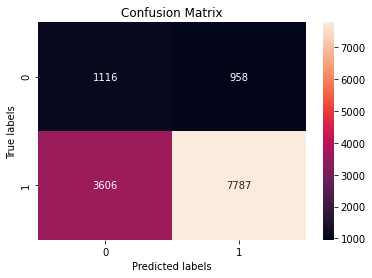

In [ ]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True, ax = ax,fmt='g');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

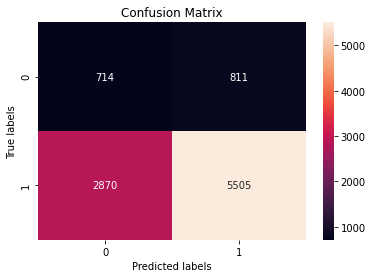

In [ ]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True, ax = ax,fmt='g');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

### 2.5 Feature selection with `SelectKBest` 

---



In [227]:
X_train = hstack((train_categories_one_hot, train_subcategories_one_hot, train_essay_tfidf, train_title_tfidf, train_school_state_category_one_hot,train_teacher_prefix_categories_one_hot, previously_posted_projects_normalized_train, train_project_grade_category_one_hot, price_normalized_train)).tocsr()
X_cv = hstack((cv_categories_one_hot, cv_subcategories_one_hot, cv_essay_tfidf, cv_title_tfidf, cv_school_state_category_one_hot, cv_teacher_prefix_categories_one_hot, previously_posted_projects_normalized_cv, cv_project_grade_category_one_hot, price_normalized_cv)).tocsr()
X_test = hstack((test_categories_one_hot, test_subcategories_one_hot, test_essay_tfidf, test_title_tfidf, test_school_state_category_one_hot, test_teacher_prefix_categories_one_hot, previously_posted_projects_normalized_test, test_project_grade_category_one_hot, price_normalized_test)).tocsr()

In [228]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

#Selecting top 2000 best features from the generated tfidf features
selector = SelectKBest(chi2, k = 2000 )
selector.fit(X_train,y_train)
X_train_2000 = selector.transform(X_train)
X_cv_2000 = selector.transform(X_cv)
X_test_2000 = selector.transform(X_test)
print(X_train_2000.shape)
print(X_cv_2000.shape)
print(X_test_2000.shape)

(13467, 2000)
(6633, 2000)
(9900, 2000)



100%|██████████| 12/12 [03:20<00:00, 16.69s/it]


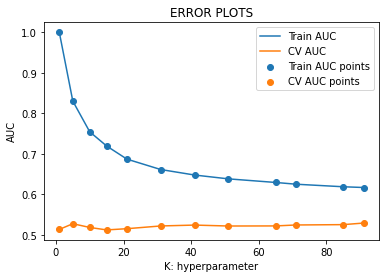

In [230]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
train_auc = []
cv_auc = [] 
K = [1, 5, 10, 15, 21, 31, 41, 51, 65, 71, 85, 91]# min k causes overfitting, max k causes underfitting
#K = range(1,50,2)
for i in  tqdm(K):
  
    neigh5 = KNeighborsClassifier(n_neighbors=i,algorithm='brute')# takes the k from the  i th list value
    neigh5.fit(X_train_2000, y_train)# fit the model
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh5.predict_proba(X_train_2000)[:,1]#Return probability estimates for the  set1x ,for the class label 1 or +ve.
    y_cv_pred =  neigh5.predict_proba(X_cv_2000)[:,1]#Return probability estimates for the setcvx,for the class label 1 or +ve .
    
    # roc curve
    #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')


plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()                

In [232]:
score_t_train = [x for x in train_auc]
score_t_cv = [x for x in cv_auc]

diff_score_train_cv = list(set(score_t_train) - set(score_t_cv))
opt_t_cv = K[diff_score_train_cv.index(min(diff_score_train_cv))]
best_k=opt_t_cv
print(best_k)

91


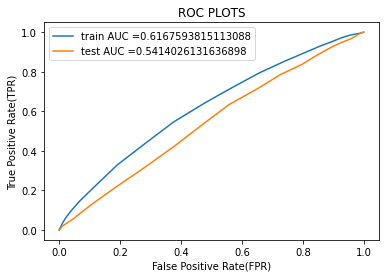

In [233]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh5 = KNeighborsClassifier(n_neighbors=best_k,algorithm='brute')
neigh5.fit(X_train_2000 ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  neigh5.predict_proba(X_train_2000)[:,1]#Return probability estimates for the  set1x ,for the class label 1 or +ve.
y_test_pred =  neigh5.predict_proba(X_test_2000)[:,1]#Return probability estimates for the setcvx,for the class label 1 or +ve .

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh5.predict_proba(X_train_2000)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh5.predict_proba(X_test_2000)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC PLOTS")
plt.show()

In [240]:
from sklearn.metrics import classification_report
print(classification_report(y_train,neigh5.predict(X_train_2000) ))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2074
           1       0.85      1.00      0.92     11393

    accuracy                           0.85     13467
   macro avg       0.42      0.50      0.46     13467
weighted avg       0.72      0.85      0.78     13467



In [241]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.3409217082576463 for threshold 0.857
Train confusion matrix
[[1297  777]
 [5182 6211]]
Test confusion matrix
[[ 814  711]
 [3952 4423]]


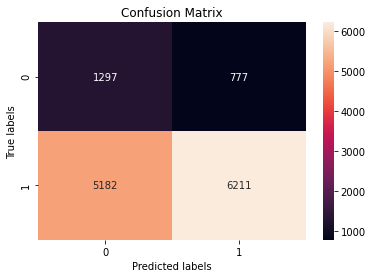

In [236]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True, ax = ax,fmt='g');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

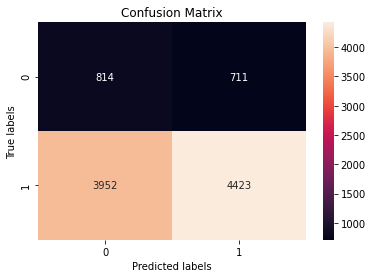

In [237]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True, ax = ax,fmt='g');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

<h1>3. Conclusions</h1>

In [1]:
# Please compare all your models using Prettytable library
# Please compare all your models using Prettytable library
#how to use pretty table http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

tb = PrettyTable()
tb.field_names= ("Vectorizer", "Model","HyperParameter" ,"AUC on train data","AUC on test data")
tb.add_row(["BOW", "Auto", 91, 65.54943, 59.94678])
tb.add_row(["Tf-Idf", "Auto", 85, 62.59604, 55.83209])
tb.add_row(["AVG-W2v", "Auto", 91, 62.12013, 55.75453])
tb.add_row(["Tf-Idf W2v", "Auto", 85, 65.30118, 59.52364])
tb.add_row(["Top 2000 features", "Auto", 91, 61.67593, 54.14026])
print(tb.get_string(titles = "KNN - Observations"))
#print(tb)

+-------------------+-------+----------------+-------------------+------------------+
|     Vectorizer    | Model | HyperParameter | AUC on train data | AUC on test data |
+-------------------+-------+----------------+-------------------+------------------+
|        BOW        |  Auto |       91       |      65.54943     |     59.94678     |
|       Tf-Idf      |  Auto |       85       |      62.59604     |     55.83209     |
|      AVG-W2v      |  Auto |       91       |      62.12013     |     55.75453     |
|     Tf-Idf W2v    |  Auto |       85       |      65.30118     |     59.52364     |
| Top 2000 features |  Auto |       91       |      61.67593     |     54.14026     |
+-------------------+-------+----------------+-------------------+------------------+
